In [1]:
import numpy as np
import torch
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from scipy.io import loadmat
import os
import time
import scipy

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

device

device(type='cuda', index=0)

In [3]:
# data_path = '/content/drive/My Drive/' 
data_path = '/home/ab/Documents/DISK2TB/SaudiAramco/3D_geoproject/data/' 

In [4]:
tresh = 127
filename = "Uniform_3_0.mat"
#filename =  'Normal_1_0.5.mat' #'Mono_2_0.5.mat'
data3d = (loadmat(data_path+filename)["ctImage"] > tresh).astype(np.float)
#bwImage = rawMatData["bwImage"]
# ctImage = rawMatData["ctImage"]

SKIP = 2
sublattice = [slice(None,512,SKIP)]*3

data3d = torch.tensor(data3d[sublattice]).to(device)

<ipython-input-4-793ca46ab903>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data3d = torch.tensor(data3d[sublattice]).to(device)


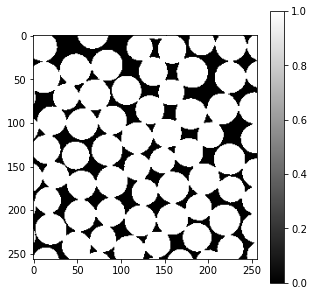

In [5]:
selection = (slice(None), slice(None),0)

plt.figure(figsize=(5,5))
plt.imshow(data3d[selection].cpu(),  cmap='gray')
plt.colorbar();

In [6]:
from ipypb import ipb
tqdm_notebook = ipb
import time

In [7]:
from torch.utils.data import Dataset, DataLoader

class discreteDataset(Dataset):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def __len__(self):
        return np.prod(self.shape)

    def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        indices = np.unravel_index(idx, self.shape)
        
        return indices

In [8]:
import edt
def sdf(dat):
    dat = dat.astype(dtype=np.float32)
    return edt.edt(dat) - edt.edt(1.-dat)

def tsdf(dat, mu=3):
    return sdf(dat).clip(-mu, mu)

In [9]:
MODE = '2D'
if MODE =='3D':
    data_sdf = sdf(data3d.cpu().numpy())
    dat = torch.tensor(data_sdf[selection]).to(device)
else:
    dat = torch.tensor(sdf(data3d[selection].cpu().numpy())).to(device)

In [10]:
## Looking at Fourier harmonics

In [11]:
def roll(arr):
    Nx, Ny, Nz = arr.shape
    arr = np.roll(arr, axis=0, shift=Nx//2) 
    arr = np.roll(arr, axis=1, shift=Ny//2)
    arr = np.roll(arr, axis=2, shift=Nz//2)
    return arr

def unroll(arr):
    Nx, Ny, Nz = arr.shape
    arr = np.roll(arr, axis=0, shift=-Nx//2) 
    arr = np.roll(arr, axis=1, shift=-Ny//2) 
    arr = np.roll(arr, axis=2, shift=-Nz//2) 
    return arr

In [12]:
# dat_fft = roll(scipy.fft.fftn(dat.cpu().numpy()))

In [13]:
# dr, di = np.real(dat_fft), np.imag(dat_fft)

In [14]:
def two_plots(a, b, cmap='viridis', titles=None):
    fig, axs = plt.subplots(1, 2,figsize=(11,11))
    if not isinstance(cmap, str):
        cmap_0 = cmap[0]
        cmap_1 = cmap[1]
    else:
        cmap_0 = cmap
        cmap_1 = cmap
        
    pcm = axs[0].imshow(a, cmap=cmap_0, interpolation='none')
    
    fig.colorbar(pcm, ax=axs[0], fraction=.0452)
    pcm2 = axs[1].imshow(b, cmap=cmap_1, interpolation='none')
    fig.colorbar(pcm2, ax=axs[1], fraction=.0452)
    if titles is not None:
        axs[0].set_title(titles[0])
        axs[1].set_title(titles[1])

In [15]:
def reverse(a,b, unroll_a=True):
    if unroll_a:
        a = unroll(a)
    z = np.exp(a + 1j*b)
    return z


def sigmoid(x):
    return  1./(1. + np.exp(-x))

def lowrankify_r1(a1, fix_boundaries=True):
    a1 = torch.tensor(a1)
    u,s,v = torch.svd(a1)
    u = u[:, 0:1]
    v = v[:, 0:1]
    if fix_boundaries:
        K = (KERNEL_SIZE-1) //2
        u[:K,0] = u[K+1,0]
        u[-K:,0] = u[-K-1,0]
        v[:K,0] = v[K+1,0]
        v[-K:,0] = v[-K-1,0]
    
    return torch.matmul(u, v.T)*s[0]

# Fitting 3D FFT

In [16]:
from ipypb import ipb

In [17]:
N = data3d.shape[0]

re = torch.ones([N,N,N], requires_grad=True, device='cuda:0')
im = torch.ones([N,N,N], requires_grad=True, device='cuda:0')


# up = torch.nn.Upsample(scale_factor=2, mode='nearest').to(device)
L = torch.nn.MSELoss()

# L = torch.nn.BCELoss()

losses = []
lrs = [1e7]
n_epochs = 100
torch.autograd.set_detect_anomaly(True)
for lr in lrs:
    optimizer = torch.optim.Adam(params=[re, im], lr=lr)
    for epoch in ipb(range(n_epochs)):
#         im = up(im0.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
        optimizer.zero_grad()
        spectrum = torch.stack([re,im], dim=-1)
        pic = torch.ifft(spectrum, signal_ndim=3)[...,0].double()
        loss = L(pic.sigmoid(), data3d)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().
                      cpu())
        

 [████████████████████████████████████████████████████████████] 100/100 [00:07<00:00, 0.07s/it]

<ipython-input-17-f7eb8b069ad2>:22: UserWarning: The function torch.ifft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.ifftn. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:578.)
  pic = torch.ifft(spectrum, signal_ndim=3)[...,0].double()


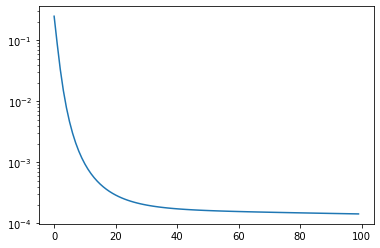

In [18]:
plt.semilogy(losses)

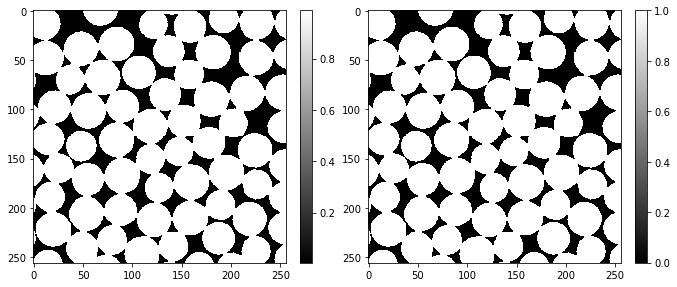

In [19]:
two_plots(pic[selection].detach().cpu().sigmoid(), data3d[selection].detach().cpu(), cmap=['gray', 'gray'])

In [20]:
def autocorr(bin_data):
    spectrum = torch.stack([bin_data, torch.zeros_like(bin_data)], dim=-1)
    re, im = torch.fft(spectrum, signal_ndim=3).T
    abs2 = re**2 + im**2
    spectrum = torch.stack([abs2, torch.zeros_like(abs2)], dim=-1)
    denom = torch.sum((bin_data.detach())**2)
    re, _ = torch.ifft(spectrum, signal_ndim=3).T / denom
    return re

In [21]:
corr = autocorr(pic.sigmoid())

<ipython-input-20-ee02b85e6cbe>:3: UserWarning: The function torch.fft is deprecated and will be removed in PyTorch 1.8. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.fftn. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:567.)
  re, im = torch.fft(spectrum, signal_ndim=3).T


In [22]:
def roll_torch_3d(dat, N=None):
    if N is None:
        N = dat.shape[0]
    return torch.roll(dat, shifts=(N//2,N//2,N//2), dims=(0,1,2))
                      
def unroll_torch_3d(dat, N=None):
    if N is None:
        N = dat.shape[0]
    return torch.roll(dat, shifts=(-N//2,-N//2,-N//2), dims=(0,1,2))
               


# plt.imshow(unroll_torch_2d(mapping))
# plt.colorbar()

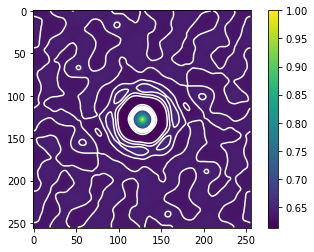

In [40]:
img = roll_torch_3d(corr.detach().cpu())[:,:,N//2]

plt.imshow(img)
plt.colorbar()
plt.contour(img, levels=[0.63, 0.64, 0.65, 0.66, 0.67, 0.68], colors=['white'])


In [217]:
torch.max(img)

tensor(0.6097, dtype=torch.float64)

In [180]:
# plt.imshow(re[:,:,N//2-1].detach().cpu()/denom)
# plt.colorbar()

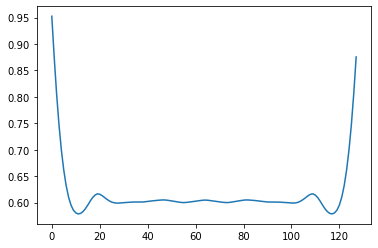

In [182]:
plt.plot(corr[0,:,0].cpu().detach())

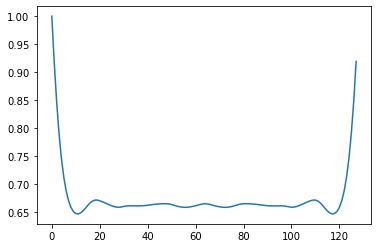

In [148]:
plt.plot(corr[0,:,0].cpu())

In [ ]:
plt.plot(corr[0,:,0].cpu())

In [89]:
import porespy

In [90]:
ans = porespy.metrics.two_point_correlation_fft(data.cpu().detach())

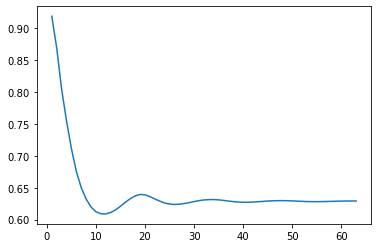

In [91]:
plt.plot(*ans)

### attempt to plot 2-point correlation

In [31]:
power_spectrum = torch.stack([re**2 + im**2, torch.zeros_like(re)], dim=-1)
corr = torch.ifft(power_spectrum, signal_ndim=3)[...,0]

In [34]:
# torch.fft(data3d, signal_ndim=3)

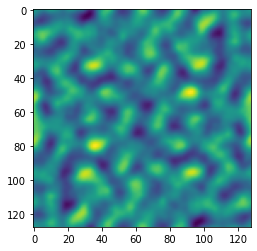

In [192]:
plt.imshow(corr[:,:,N//2].detach().cpu())

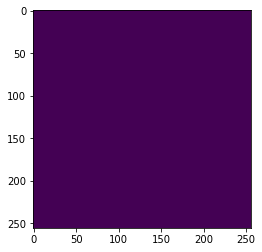

In [36]:
plt.imshow(corr[:,N//2,:].detach().cpu())

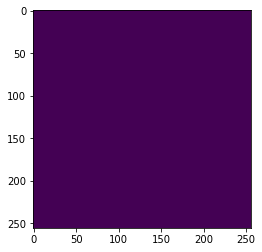

In [37]:
plt.imshow(corr[N//2,:,:].detach().cpu())

In [38]:
y = torch.view_as_complex(spectrum[selection].detach().cpu())
# re, im = .T.detach().cpu()
# two_plots(re, im)

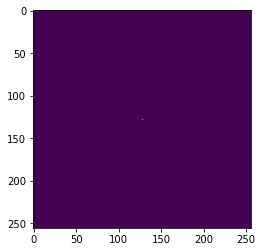

In [39]:
plt.imshow(torch.roll(y.abs(), shifts=(N//2,N//2), dims=(0,1)))

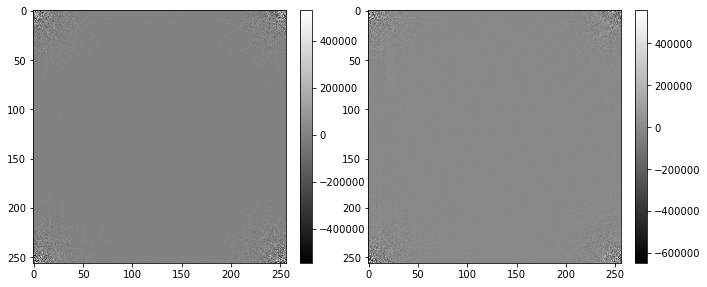

In [395]:
two_plots(y.real, y.imag, cmap=['gray', 'gray'])

In [396]:
# plt.imshow(torch.nn.functional.pad(pic, pad=[5,10,20,30], mode='constant', value=0).detach().cpu())

# Fitting rotationally-symmetric thingy

In [397]:
# центральная точка по координатам смещена в сторону увеличения индексов!

In [22]:
N = data3d.shape[0]

In [23]:
max_r = np.ceil(N/2*np.sqrt(3)).astype(int)
# uno = 1./(10+ torch.linspace(0, max_r, max_r, requires_grad=True, device='cuda:0', dtype=torch.double))


In [24]:
# plt.plot(uno.detach().cpu())

In [26]:
xx, yy, zz = torch.meshgrid([torch.linspace(-N//2,N//2-1, N)]*3) # memory bottleneck
mapping = torch.sqrt(xx**2 + yy**2 + zz**2) # memory bottleneck
addr = mapping.reshape(-1).round().clip(min=0,max=max_r-1).long()
del xx, yy, mapping

In [34]:
# plt.imshow(ans[:,:,0].detach().cpu().sigmoid())

In [35]:
# torch.max(mapping.reshape(-1,1))

In [36]:
# y.abs().shape|

In [37]:
max_r

222

In [27]:
N = data3d.shape[0]
L = torch.nn.MSELoss()
losses = []

max_r = np.ceil(N/2*np.sqrt(3)).astype(int)
uno = torch.zeros(max_r, requires_grad=True, device=device)

new_arg = torch.zeros((N,N,N), requires_grad=True, device=device)


lrs = [1e0, 1e-1, 1e-2]
n_epochs = 100

for lr in lrs:
    optimizer = torch.optim.Adam(params=[uno, new_arg], lr=lr)
    for epoch in ipb(range(n_epochs)):
        optimizer.zero_grad()
        
        new_abs = torch.exp(unroll_torch_3d(uno[addr].reshape(N,N,N)))
        new_real = new_abs*torch.cos( new_arg.tanh()*np.pi)
        new_imag = new_abs*torch.sin( new_arg.tanh()*np.pi)
        new_spektrum = torch.stack([new_real, new_imag], dim=-1 )
        pic = torch.ifft(new_spektrum, signal_ndim=3)[...,0].double()
        #in case of slices, loss = L(pic[idxs], data3d[idxs]
        loss = L(pic.sigmoid(), data3d)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().
                      cpu())
        

 [████████████████████████████████████████████████████████████] 100/100 [00:40<00:00, 0.40s/it]

 [████████████████████████████████████████████████████████████] 100/100 [00:41<00:00, 0.41s/it]

 [████████████████████████████████████████████████████████████] 100/100 [00:40<00:00, 0.40s/it]

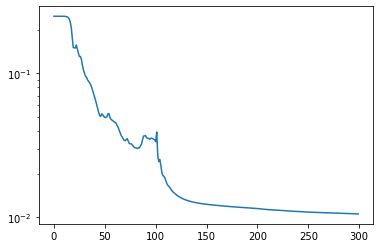

In [28]:
plt.semilogy(losses)

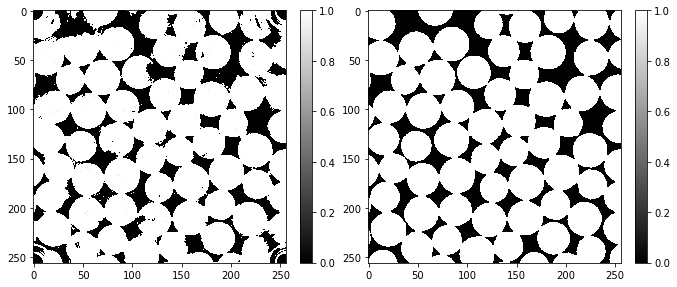

In [29]:
selection = (slice(None), slice(None), 0)
two_plots(pic[selection].detach().cpu().sigmoid(), data3d[selection].detach().cpu(), cmap=['gray', 'gray'])

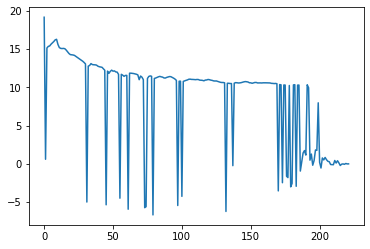

In [33]:
plt.plot(uno.detach().cpu())

In [34]:
selection

(slice(None, None, None), slice(None, None, None), 0)

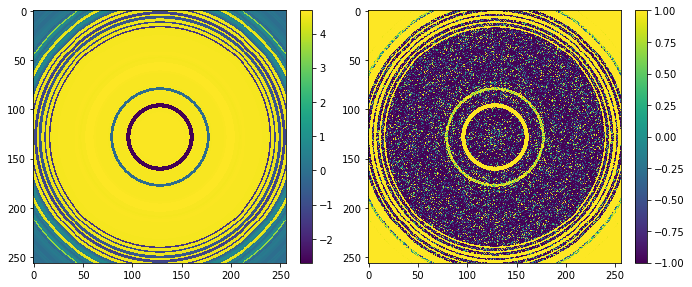

In [36]:
argus = roll_torch_3d(new_arg).cpu().detach()[selection]
two_plots(torch.log10(roll_torch_3d(new_abs)[selection].cpu().detach()), (argus.tanh()*np.pi).cos())

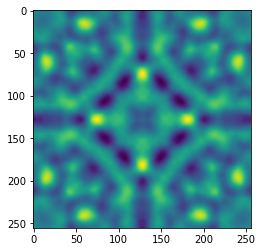

In [424]:
power_spektrum = torch.stack([new_abs**2, torch.zeros_like(new_abs)], dim=-1 )
corr = torch.ifft(power_spektrum, signal_ndim=3)[...,0].double()
plt.imshow(corr[:,N//2,:].detach().cpu())

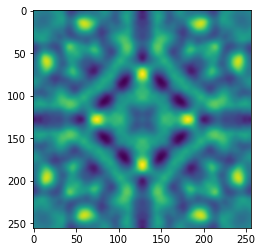

In [425]:
plt.imshow(corr[N//2,:,:].detach().cpu())

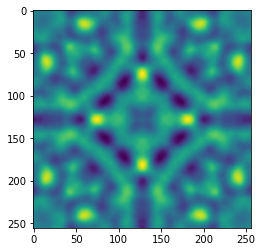

In [426]:
plt.imshow(corr[:,:,N//2].detach().cpu())

In [427]:
# # import scipy.signal
# # KERNEL_SIZE = 3
# # a1 = scipy.signal.medfilt2d(np.abs(argus) % (np.pi/2), kernel_size=KERNEL_SIZE)

# plt.figure(figsize=(10,10))
# plt.imshow((argus.tanh()*np.pi).cos(), cmap='viridis')
# plt.colorbar()

### Experiments with cutting out the tail of the abs curve

In [428]:
import copy
uno2 = copy.copy(uno.detach())

In [429]:
# uno2[uno2<5]=0

In [430]:
new_abs = torch.exp(unroll_torch_3d(uno[addr].reshape(N,N,N)))
new_real = new_abs*torch.cos( new_arg)
new_imag = new_abs*torch.sin( new_arg)
new_spektrum = torch.stack([new_real, new_imag], dim=-1 )
pic = torch.ifft(new_spektrum, signal_ndim=3)[selection].double()

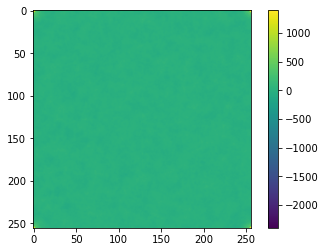

In [431]:
plt.imshow(pic[...,0].detach().cpu())
plt.colorbar()

# Sliced dataset

In [22]:
from torch.utils.data import Dataset, DataLoader

class SlicedDataset(Dataset):
    def __init__(self, shape, mask):
        super().__init__()
        self.shape = shape
        self.mask = mask
        self.indices = np.arange(np.prod(shape))[mask.flatten()]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]
        indices = np.unravel_index(idx, self.shape)
        
        return indices

In [23]:
# select central slices

mask = np.zeros_like(data3d.cpu(), dtype=np.bool)
Nx, Ny, Nz = data3d.shape
mask[Nx//2,:,:] = True
mask[Nx//4,:,:] = True
mask[3*Nx//4,:,:] = True
mask[:,Ny//2,:] = True
mask[:,Ny//4,:] = True
mask[:,3*Ny//4,:] = True
mask[:,:,Nz//2] = True
mask[:,:,Nz//4] = True
mask[:,:,3*Nz//4] = True
ds_slices = SlicedDataset(data3d.shape, mask)

In [27]:
Z = np.prod(data3d.shape)
sampler = torch.utils.data.sampler.BatchSampler(
    torch.utils.data.sampler.RandomSampler(ds_slices),
    batch_size=2**20,
    drop_last=False)

dl = DataLoader(ds_slices, sampler=sampler)


N = data3d.shape[0]
L = torch.nn.MSELoss()
losses = []

max_r = np.ceil(N/2*np.sqrt(2)).astype(int)
uno = torch.zeros(max_r, requires_grad=True, device=device)

new_arg = torch.zeros((N,N,N), requires_grad=True, device=device)


lrs = [1e0, 1e-1, 1e-2]
n_epochs = 100

for lr in lrs:
    optimizer = torch.optim.Adam(params=[uno, new_arg], lr=lr)
    for epoch in ipb(range(n_epochs)):
        for x in dl:
            optimizer.zero_grad()
            new_abs = torch.exp(unroll_torch_3d(uno[addr].reshape(N,N,N)))
            new_real = new_abs*torch.cos( new_arg.tanh()*np.pi)
            new_imag = new_abs*torch.sin( new_arg.tanh()*np.pi)
            new_spektrum = torch.stack([new_real, new_imag], dim=-1 )
            pic = torch.ifft(new_spektrum, signal_ndim=3)[...,0].double()
            #in case of slices, loss = L(pic[idxs], data3d[idxs]
            loss = L(pic.sigmoid()[x], data3d[x])
            loss.backward(retain_graph=True)
            optimizer.step()
            losses.append(loss.detach().cpu())

 [████████████████████████████████████████████████████████████] 100/100 [01:34<00:01, 0.94s/it]

<ipython-input-27-0a97508fae79>:32: UserWarning: The function torch.ifft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.ifftn. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:578.)
  pic = torch.ifft(new_spektrum, signal_ndim=3)[...,0].double()


 [████████████████████████████████████████████████████████████] 100/100 [01:33<00:01, 0.93s/it]

 [████████████████████████████████████████████████████████████] 100/100 [01:33<00:01, 0.93s/it]

In [ ]:
corr.shape

In [ ]:
plt.semilogy(losses)

In [ ]:
plt.plot(uno.detach().cpu())

In [ ]:
selection = (slice(None), slice(None), 0)
argus = roll_torch_3d(new_arg).cpu().detach()[selection]
two_plots(roll_torch_3d(new_abs)[selection].cpu().detach(), (argus.tanh()*np.pi).cos())
two_plots(pic[selection].detach().cpu().sigmoid(), data3d[selection].detach().cpu(), cmap=['gray', 'gray'])

In [145]:
import subprocess
ans = subprocess.run(["ls"], capture_output=True)

In [146]:
ans.stdout

b'data1.dat\nFFT_backprop_2D.ipynb\nFFT_backprop_3D.ipynb\nFFT_porous_media.ipynb\nfixed_cross.py\nfixed_tools.py\nfourier_encoding_3D.ipynb\nfourier_encoding_3D_scaling_experiments.ipynb\nfourier_encoding.ipynb\nmain.ipynb\nnewplan_128.png\nnewplan_512.png\npics\npics_eikonal\nplan2d.png\nplan2.png\npoetry.lock\nporous_media.ipynb\npyproject.toml\nQTT_eikonal.ipynb\nREADME.md\ntensorfunbound\ntests_interpolation.ipynb\ntests_interpolation_of_eikonal.ipynb\ntntorch_eikonal.ipynb\ntntorch_eikonal_new_backprop2.ipynb\ntntorch_eikonal_new_backprop.ipynb\nttpy_als.ipynb\nTucker_eikonal.ipynb\nTucker_porous_media.ipynb\nTucker_porous_media_penalty.ipynb\nUntitled.ipynb\nvoxels_porous_media.ipynb\n'

In [ ]:
# Save the data for solver
np.savetxt("data1.dat", res_3D.flatten(), fmt='%1.0f')